In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1cef56f7400>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

In [11]:
first_row2 = session.query(Station).first()
first_row2.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1cef5704340>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'latitude': 21.2716}

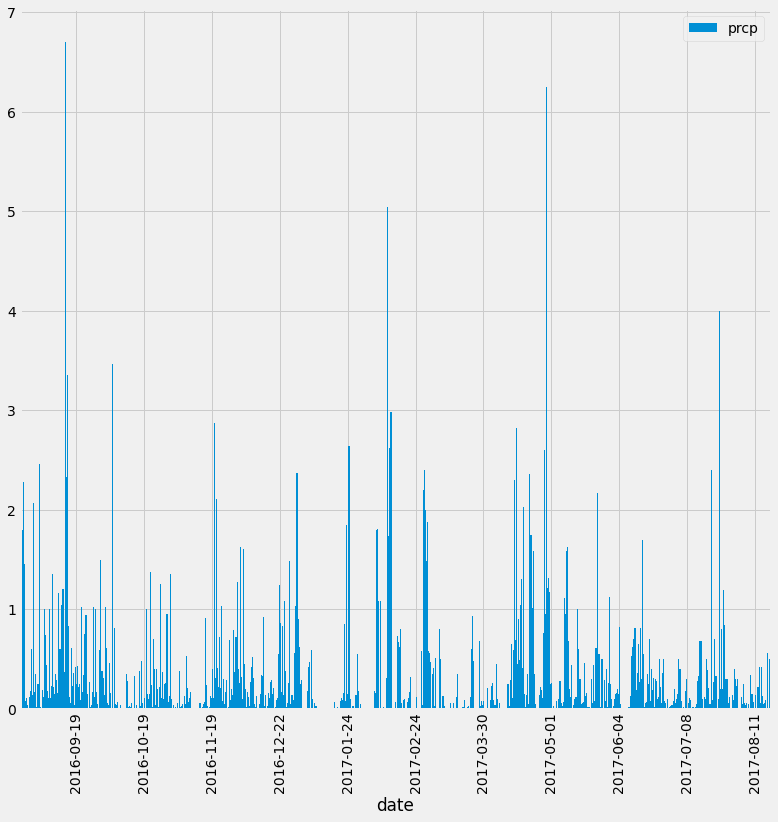

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

lastdate = session.query(func.max(Measurement.date))
enddate = dt.datetime.strptime(lastdate[0][0], '%Y-%m-%d').date()
startdate = enddate.replace(enddate.year - 1)

# Perform a query to retrieve the data and precipitation scores

#data12mo = session.query(Measurement.date, func.sum(Measurement.prcp)).group_by(Measurement.date).filter(Measurement.date >= startdate)

data12mo = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= startdate)


xts = np.arange(startdate, enddate, np.timedelta64(60, 'D'))



# # Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(data12mo.statement, engine)
df.dropna(axis = 0, inplace = True)
df.set_index('date', inplace = True)
# # # Sort the dataframe by date
df.sort_values(['date'], inplace = True)
# # # Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind='bar',figsize=(12,12),width=3)
# plt.xticks(xts)
# plt.figure(figsize=(12,12))

# plt.bar(df.index, df['prcp'],width=1)



# fig, ax = plt.subplots()
# ax.plot('date', 'adj_close', data=data)

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=6)
# ax.xaxis.set_major_locator(fmt_half_year)
plt.gca().xaxis.set_major_locator(fmt_half_year)
plt.xticks(rotation=90)
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
print(stations)

9


In [64]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station.label('station'), func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by(desc('count'))
substations = station_counts.subquery()       
allsations = station_counts.all()


In [75]:
activestation = session.query(substations.c.station,func.max(substations.c.count))

(i, j) = activestation[0]
astation = i

In [81]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_stats = session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == astation)
for i in station_stats:
    print(i)

(85.0, 54.0, 71.66378066378067)


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
